# PyTorch Tensors and Autograd Tutorial

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/maheshghanta/Codes/blob/master/PyTorch_Tutorials/1.Tensors_and_Autograd.ipynb)

## Overview: Scalars, Vectors, and Tensors

### **Scalar**
- Single value (0D): `5`
- Use: loss, learning rate

### **Vector**
- 1D array: `[1,2,3]`
- Use: embeddings, features

### **Matrix**
- 2D array: `[[1,2],[3,4]]`
- Use: weights, batch data

### **Tensor**
- ND array: generalizes all above
- 4D example: `(batch, channels, height, width)`
- Use: images, video, any ND data

**In PyTorch, everything is a tensor!**

## Setup and Imports

In [1]:
import torch
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler


from torch import nn
import numpy as np
import time
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter

import os
from datetime import datetime

print(f"PyTorch: {torch.__version__}")
print(f"NumPy: {np.__version__}")

PyTorch: 2.9.0
NumPy: 2.3.4


## Tensor Operations: PyTorch vs NumPy

### 1. Creating Tensors

In [2]:
# From lists
np_arr = np.array([1,2,3])
torch_t = torch.tensor([1,2,3])
print("NumPy:", np_arr)
print("PyTorch:", torch_t)

# Zeros, ones, random
print("\nZeros:", torch.zeros(2,3).shape)
print("Ones:", torch.ones(2,3).shape)
print("Random:", torch.randn(2,2))

NumPy: [1 2 3]
PyTorch: tensor([1, 2, 3])

Zeros: torch.Size([2, 3])
Ones: torch.Size([2, 3])
Random: tensor([[ 0.9587,  0.9593],
        [-2.2685,  0.0325]])


### 2. NumPy ↔ PyTorch

In [3]:
np_a = np.array([[1,2],[3,4]])
torch_a = torch.from_numpy(np_a)
print("NumPy→PyTorch:", torch_a)
print(torch_a.dtype)
torch_b = torch.tensor([[5,6],[7,8]])
np_b = torch_b.numpy()
print("PyTorch→NumPy:", np_b)
print(np_b.dtype)

# They share memory!
np_a[0,0] = 999
print("Modified NumPy affects PyTorch:", torch_a)

NumPy→PyTorch: tensor([[1, 2],
        [3, 4]])
torch.int64
PyTorch→NumPy: [[5 6]
 [7 8]]
int64
Modified NumPy affects PyTorch: tensor([[999,   2],
        [  3,   4]])


### 3. Basic Operations

In [4]:
a = torch.tensor([[1,2],[3,4]])
b = torch.tensor([[5,6],[7,8]])

print("Add:", a + b)
print("Multiply:", a * b)
print("Matmul:", torch.matmul(a, b))
print("Transpose:", a.T)
print("Sum:", a.sum().item())

Add: tensor([[ 6,  8],
        [10, 12]])
Multiply: tensor([[ 5, 12],
        [21, 32]])
Matmul: tensor([[19, 22],
        [43, 50]])
Transpose: tensor([[1, 3],
        [2, 4]])
Sum: 10


### 4. Reshaping

In [5]:
t = torch.arange(12)
print("Original:", t.shape)
print("Reshaped 3x4:\n", t.reshape(3,4))
print("View 2x6:\n", t.view(2,6))
print("Index [0,1]:", t.reshape(3,4)[0,1].item())

Original: torch.Size([12])
Reshaped 3x4:
 tensor([[ 0,  1,  2,  3],
        [ 4,  5,  6,  7],
        [ 8,  9, 10, 11]])
View 2x6:
 tensor([[ 0,  1,  2,  3,  4,  5],
        [ 6,  7,  8,  9, 10, 11]])
Index [0,1]: 1


### 5. Performance (GPU)

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}")

size = 1000
x_cpu = torch.randn(size, size)
y_cpu = torch.randn(size, size)

start = time.time()
result = torch.matmul(x_cpu, y_cpu)
print(f"CPU time: {time.time()-start:.4f}s")

if torch.cuda.is_available():
    x_gpu = x_cpu.to(device)
    y_gpu = y_cpu.to(device)
    torch.cuda.synchronize()
    start = time.time()
    result_gpu = torch.matmul(x_gpu, y_gpu)
    torch.cuda.synchronize()
    print(f"GPU time: {time.time()-start:.4f}s")

Device: cpu
CPU time: 0.0014s


## Manual Backpropagation

### Function: $f(x,y) = x^2 + 2xy + y^2$

**Derivatives:**
- $\\frac{\\partial f}{\\partial x} = 2x + 2y$
- $\\frac{\\partial f}{\\partial y} = 2x + 2y$

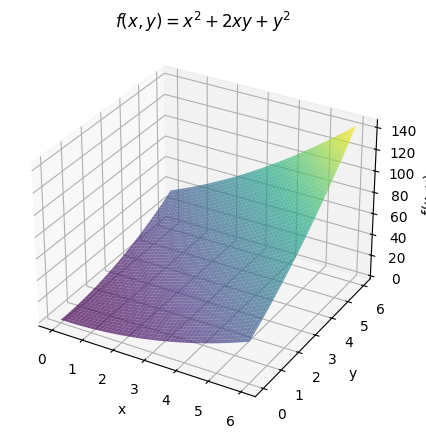

In [7]:
# Prepare meshgrid for x and y in reasonable range
x_vals = np.linspace(0, 6, 100)
y_vals = np.linspace(0, 6, 100)
X, Y = np.meshgrid(x_vals, y_vals)
F = X**2 + 2*X*Y + Y**2  # The function f = x**2 + 2*x*y + y**2

fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, F, cmap='viridis', alpha=0.7)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('f(x, y)')
ax.set_title(r"$f(x, y) = x^2 + 2xy + y^2$")
plt.show()

In [8]:
def forward(x, y):
    return x**2 + 2*x*y + y**2

def backward(x, y):
    return 2*x + 2*y, 2*x + 2*y

x, y = 3.0, 4.0
out = forward(x, y)
gx, gy = backward(x, y)

print(f"f({x},{y}) = {out}")
print(f"∂f/∂x = {gx}")
print(f"∂f/∂y = {gy}")

f(3.0,4.0) = 49.0
∂f/∂x = 14.0
∂f/∂y = 14.0


### Complex Example: $y = \\sigma(Wx + b)$

In [9]:
def sigmoid(z): return 1/(1+np.exp(-z))
def sigmoid_grad(z): s=sigmoid(z); return s*(1-s)

W = np.array([[0.5,-0.3],[0.2,0.8]])
b = np.array([0.1,-0.2])
x = np.array([1.0,2.0])

# Forward
z = W @ x + b
y = sigmoid(z)
print("Forward:", y)

# Backward
grad_z = sigmoid_grad(z)
grad_W = np.outer(grad_z, x)
grad_b = grad_z
grad_x = W.T @ grad_z
print("∂L/∂W:\n", grad_W)
print("∂L/∂b:", grad_b)

Forward: [0.5        0.83201839]
∂L/∂W:
 [[0.25       0.5       ]
 [0.13976379 0.27952758]]
∂L/∂b: [0.25       0.13976379]


## PyTorch Autograd

Automatic differentiation - no manual gradient calculation needed!

### 1. Simple Function

In [10]:
x = torch.tensor(3.0, requires_grad=True)
y = torch.tensor(4.0, requires_grad=True)

f = x**2 + 2*x*y + y**2
print(f"f = {f.item()}")

f.backward()
print(f"∂f/∂x = {x.grad.item()}")
print(f"∂f/∂y = {y.grad.item()}")

f = 49.0
∂f/∂x = 14.0
∂f/∂y = 14.0


### 2. Neural Network Layer

In [11]:
W = torch.tensor([[0.5,-0.3],[0.2,0.8]], requires_grad=True, dtype=torch.float32)
b = torch.tensor([0.1,-0.2], requires_grad=True, dtype=torch.float32)
x = torch.tensor([1.0,2.0], requires_grad=True, dtype=torch.float32)

z = torch.matmul(W, x) + b
y = torch.sigmoid(z)
loss = y.sum()

loss.backward()
print("∂L/∂W:\n", W.grad.numpy())
print("∂L/∂b:", b.grad.numpy())


∂L/∂W:
 [[0.25      0.5      ]
 [0.1397638 0.2795276]]
∂L/∂b: [0.25      0.1397638]


In [12]:
class MyModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(2, 2)  # W and b are encapsulated here

    def forward(self, x):
        out = self.linear(x)
        out = torch.sigmoid(out)
        return out

simple_model = MyModel()

In [13]:
run_dir = f'runs/simple_model_{datetime.now().strftime("%Y%m%d_%H%M%S")}'
writer = SummaryWriter(run_dir)
print(f"TensorBoard logs saved to: {run_dir}")
print(f"View with: tensorboard --logdir=runs")


TensorBoard logs saved to: runs/simple_model_20251029_182231
View with: tensorboard --logdir=runs


In [14]:
# Create input tensor and add graph
x = torch.tensor([1.0,2.0], requires_grad=True, dtype=torch.float32)
# Add graph only once - this creates the computation graph visualization
writer.add_graph(simple_model, x)
writer.close()
print("Graph added successfully!")


Graph added successfully!


### 3. Autograd Features

In [15]:
# Gradient accumulation
print("1. Accumulation:")
x = torch.tensor(2.0, requires_grad=True)
for i in range(3):
    (x**2).backward()
    print(f"  Iter {i+1}: grad = {x.grad.item()}")
print("  Gradients accumulate!\n")

# Zero gradients
x.grad.zero_()
print("2. After zeroing:", x.grad.item())

# Detach
print("\n3. Detach:")
x = torch.tensor(3.0, requires_grad=True)
y = x**2
z = y.detach()
print(f"  y.requires_grad: {y.requires_grad}")
print(f"  z.requires_grad: {z.requires_grad}")

# No grad context
print("\n4. No grad (inference):")
with torch.no_grad():
    y = x**2
    print(f"  requires_grad: {y.requires_grad}")

1. Accumulation:
  Iter 1: grad = 4.0
  Iter 2: grad = 8.0
  Iter 3: grad = 12.0
  Gradients accumulate!

2. After zeroing: 0.0

3. Detach:
  y.requires_grad: True
  z.requires_grad: False

4. No grad (inference):
  requires_grad: False


## Summary: PyTorch NN Layers

### Linear
- `nn.Linear(in, out)` - Fully connected
- `nn.Bilinear()` - Bilinear transformation

### Convolutional
- `nn.Conv1d/2d/3d()` - 1D/2D/3D convolution
- `nn.ConvTranspose2d()` - Upsampling

### Pooling
- `nn.MaxPool2d()` - Max pooling
- `nn.AvgPool2d()` - Average pooling
- `nn.AdaptiveAvgPool2d()` - Adaptive pooling

### Activation
- `nn.ReLU()`, `nn.LeakyReLU()`, `nn.GELU()`
- `nn.Sigmoid()`, `nn.Tanh()`, `nn.Softmax()`

### Normalization
- `nn.BatchNorm2d()` - Batch normalization
- `nn.LayerNorm()` - Layer normalization
- `nn.GroupNorm()` - Group normalization

### Recurrent
- `nn.RNN()`, `nn.LSTM()`, `nn.GRU()`

### Transformer
- `nn.Transformer()` - Full transformer
- `nn.TransformerEncoder/Decoder()`
- `nn.MultiheadAttention()`

### Regularization
- `nn.Dropout()`, `nn.Dropout2d()`

### Embedding
- `nn.Embedding()` - Lookup table

### Loss Functions
- `nn.CrossEntropyLoss()` - Classification
- `nn.MSELoss()` - Regression
- `nn.BCEWithLogitsLoss()` - Binary classification

### Utility
- `nn.Sequential()` - Chain layers
- `nn.ModuleList/Dict()` - Dynamic layers
- `nn.Flatten()` - Flatten dimensions

### Example: Simple CNN

In [16]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d(1)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )
    
    def forward(self, x):
        x = self.features(x)
        return self.classifier(x)

model = SimpleCNN()
print(model)
params = sum(p.numel() for p in model.parameters())
print(f"\nTotal parameters: {params:,}")

SimpleCNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): AdaptiveAvgPool2d(output_size=1)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=64, out_features=256, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=256, out_features=10, bias=True)
  )
)

Total parameters: 38,794


In [ ]:
image_data = datasets.CIFAR10('data', train=True,
                              download=True)
image, label = image_data[0]

In [25]:
# Create a unique run directory with timestamp to avoid multiple graph events
run_dir = f'runs/simple_cnn_model_{datetime.now().strftime("%Y%m%d_%H%M%S")}'
writer = SummaryWriter(run_dir)
print(f"TensorBoard logs saved to: {run_dir}")

# Convert CIFAR10 image to correct PyTorch format
# CIFAR10 images are (H, W, C) format, but PyTorch CNNs need (B, C, H, W)
x = np.asarray(image)  # Shape: (32, 32, 3)
x = torch.tensor(x, dtype=torch.float32)
print(f"Original shape: {x.shape}")

# Use .permute() to rearrange dimensions from (H, W, C) to (C, H, W)
x = x.permute(2, 0, 1)  # Now shape: (3, 32, 32)
print(f"After permute: {x.shape}")

# Add batch dimension
x = x.unsqueeze(0)  # Now shape: (1, 3, 32, 32)
x.requires_grad = True
print(f"Final shape: {x.shape}")

# Add graph only once
writer.add_graph(model, x)
writer.close()
print("CNN graph added successfully!")

TensorBoard logs saved to: runs/simple_cnn_model_20251029_183802
Original shape: torch.Size([32, 32, 3])
After permute: torch.Size([3, 32, 32])
Final shape: torch.Size([1, 3, 32, 32])
CNN graph added successfully!
